In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
medium_data = pd.read_csv('medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


In [4]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [5]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [6]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [7]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [8]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [9]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68])

In [10]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)


print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


In [14]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=10)
#print model.summary()
print(model)

Epoch 1/10
1515/1515 [==============================] - 227s 148ms/step - loss: 6.9790 - accuracy: 0.0876
Epoch 2/10
1515/1515 [==============================] - 308s 203ms/step - loss: 6.1260 - accuracy: 0.1425
Epoch 3/10
1515/1515 [==============================] - 306s 202ms/step - loss: 5.6141 - accuracy: 0.1701
Epoch 4/10
1515/1515 [==============================] - 322s 213ms/step - loss: 5.1596 - accuracy: 0.1926
Epoch 5/10
1515/1515 [==============================] - 346s 228ms/step - loss: 4.7254 - accuracy: 0.2160
Epoch 6/10
1515/1515 [==============================] - 359s 237ms/step - loss: 4.3150 - accuracy: 0.2426
Epoch 7/10
1515/1515 [==============================] - 314s 207ms/step - loss: 3.9246 - accuracy: 0.2826
Epoch 8/10
1515/1515 [==============================] - 301s 198ms/step - loss: 3.5523 - accuracy: 0.3315
Epoch 9/10
1515/1515 [==============================] - 292s 193ms/step - loss: 3.2066 - accuracy: 0.3847
Epoch 10/10
1515/1515 [=======================

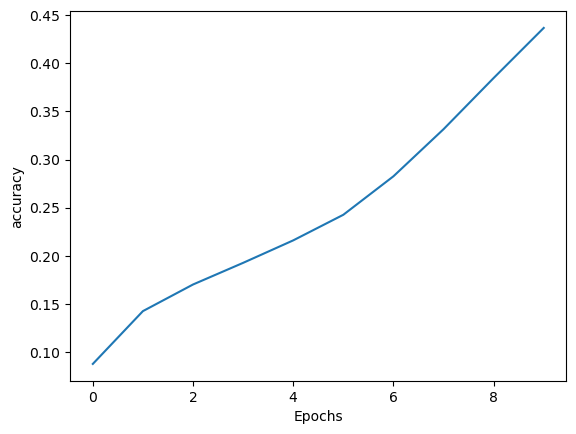

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')

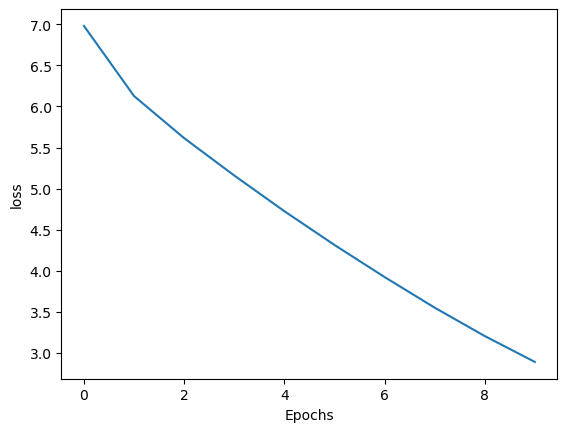

In [16]:
plot_graphs(history, 'loss')

In [18]:
model.predict("to implement")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [28]:
dic = tokenizer.word_index
text = "A Beginner’s Guide to Word Embedding"
text2 = "A step by step"
def generate(text,no_of_words):
    for i in range(no_of_words):
        tokenized_text = tokenizer.texts_to_sequences([text])[0]
        padded_seq = pad_sequences([tokenized_text],padding = "pre",maxlen = max_sequence_len-1)
        index = np.argmax(model.predict(padded_seq))
        for key,value in dic.items():
            if index+1 == value:
                text = text+" "+key
                print(text)


In [32]:
generate("this is my",3)

1/1 [==============================] - 0s 21ms/step
this is my analysis
1/1 [==============================] - 0s 20ms/step
this is my analysis how
1/1 [==============================] - 0s 20ms/step
this is my analysis how the


In [40]:
generate("How Should You ",3)

1/1 [==============================] - 0s 20ms/step
How Should You  published
1/1 [==============================] - 0s 20ms/step
How Should You  published all
1/1 [==============================] - 0s 19ms/step
How Should You  published all strong
